In [1]:
import os
import pickle
import random
import time
from contextlib import contextmanager

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from gensim.models import word2vec
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold, StratifiedKFold

from src.config import Config
from src.data import anime_id_label_encoding, load_data, user_id_label_encoding

os.chdir("/home/marumarukun/pj/my_study/atmacup_15/notebook")
pl.Config.set_tbl_rows(50)

cfg = Config.get_cnf()


In [2]:
train_df, test_df, anime_df = load_data()
train_df.head()


user_id,anime_id,score
str,str,i64
"""0008e10fb39e55447333""","""0669cc0219d468761195""",2
"""0008e10fb39e55447333""","""111adb8835b8a1a2cf54""",10
"""0008e10fb39e55447333""","""1fc8683c393432a2f9c7""",1
"""0008e10fb39e55447333""","""2290175205d55e81b197""",8
"""0008e10fb39e55447333""","""28f173b60331d5cabb0d""",9


# Anime2Vec + LightGBM

[paoさんのAnime2Vec](https://www.guruguru.science/competitions/21/discussions/92ec4042-bd1a-44ca-9250-d365f01a0978/)を使用して特徴量を作成してみます。  
ただし、今回は視聴したアニメがどれかだけではなく、ユーザーが付与したレーティングも与えられています。  
レーティングの情報を活用する方法を試し、使用しない場合と比較してみます。  


## Utility functions

In [3]:
SEED = 0


@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f"[{name}] done in {time.time() - t0:.0f} s")


def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)


seed_everything(SEED)


# Word2Vecによる特徴量エンジニアリング

以下に示す`add_w2v_features`という関数でWord2Vecを用いてアニメの特徴量とユーザーの特徴量を生成します。  

1. 各ユーザーが評価したアニメのリストを作成
2. paoさんの記事に従い、シャッフルしたリストもデータに加える
3. Word2Vecモデルを学習する
4. 各アニメのベクトルはそのままアニメの特徴ベクトルとなり、そのユーザーが評価したアニメのベクトルの平均をユーザーの特徴ベクトルとする
5. 各特徴ベクトルを元のデータに結合する

さて、ここで冒頭に述べたword2vecの作成にあたってスコアを考慮する方法を考えます。  
単にスコアの値も一つのトークンとしてリストに加えてしまうのも考えられますが、今回は1～10のレーティングなので、  
「スコアの数だけそのタイトルをリストに追加する」という手法を試してみます。

In [4]:
# my change(polas版に変更)
def add_w2v_features(train_df, test_df=None, consider_score=True, vector_size=64):
    anime_id_list = train_df["anime_id"].unique().to_list()
    user_anime_ids_socores_dict = {
        user_id: (anime_ids, scores)
        for user_id, anime_ids, scores in train_df.group_by("user_id", maintain_order=True)
        .agg(pl.col(["anime_id", "score"]))
        .iter_rows()
    }

    # スコアを考慮する場合
    # 今回は1～10のレーティングなので、スコアが5のアニメは5回、スコアが10のアニメは10回、タイトルをリストに追加する
    if consider_score:
        title_sentence_list = []
        for _, user_df in train_df.group_by("user_id", maintain_order=True):
            user_title_sentence_list = []
            for anime_id, score in user_df[["anime_id", "score"]].to_numpy():
                for _ in range(score):
                    user_title_sentence_list.append(anime_id)
            title_sentence_list.append(user_title_sentence_list)
    # スコアを考慮しない場合
    # タイトルをそのままリストに追加する
    else:
        title_sentence_list = (
            train_df.group_by("user_id", maintain_order=True).agg(pl.col("anime_id"))["anime_id"].to_list()
        )

    # ユーザごとにshuffleしたリストを作成
    shuffled_sentence_list = [random.sample(sentence, len(sentence)) for sentence in title_sentence_list]  ## <= 変更点

    # 元のリストとshuffleしたリストを合わせる
    train_sentence_list = title_sentence_list + shuffled_sentence_list

    # word2vecのパラメータ
    w2v_params = {
        "vector_size": vector_size,  ## <= 変更点
        "seed": SEED,
        "min_count": 1,
        "workers": 1,
    }

    # word2vecのモデル学習
    model = word2vec.Word2Vec(train_sentence_list, **w2v_params)

    # ユーザーごとの特徴ベクトルと対応するユーザーID
    user_embeddings = {}

    # my change(スコアを考慮する場合、スコアによって重みをつける処理を追加)
    if consider_score:
        for user_id, (anime_ids, scores) in user_anime_ids_socores_dict.items():
            weighted_embeddings = []
            total_score = sum(scores)
            for anime_id, score in zip(anime_ids, scores, strict=True):
                weight = score / total_score
                weighted_embeddings.append(model.wv[anime_id] * weight)
            user_embeddings[user_id] = np.sum(weighted_embeddings, axis=0)
    else:
        for user_id, (anime_ids, _) in user_anime_ids_socores_dict.items():
            user_embeddings[user_id] = np.mean([model.wv[anime_id] for anime_id in anime_ids], axis=0)

    # アイテムごとの特徴ベクトルと対応するアイテムID
    item_embeddings = {aid: model.wv[aid] for aid in anime_id_list}

    # データフレームを作成
    user_embeddings_df = pl.DataFrame(user_embeddings).transpose(include_header=True, header_name="user_id")
    item_embeddings_df = pl.DataFrame(item_embeddings).transpose(include_header=True, header_name="anime_id")

    # データフレームのカラム名をリネーム
    user_embeddings_df.columns = ["user_id"] + [f"user_embedding_{i}" for i in range(vector_size)]
    item_embeddings_df.columns = ["anime_id"] + [f"item_embedding_{i}" for i in range(vector_size)]

    train_df = train_df.join(user_embeddings_df, on="user_id", how="left")
    train_df = train_df.join(item_embeddings_df, on="anime_id", how="left")

    if test_df is not None:
        test_df = test_df.join(user_embeddings_df, on="user_id", how="left")
        test_df = test_df.join(item_embeddings_df, on="anime_id", how="left")
        return train_df, test_df

    return train_df


# Training and prediction

## Ratingを考慮する場合

In [5]:
# anime2vec + レーティング
train_df, test_df = add_w2v_features(train_df, test_df, consider_score=True)
train_df.head()


user_id,anime_id,score,user_embedding_0,user_embedding_1,user_embedding_2,user_embedding_3,user_embedding_4,user_embedding_5,user_embedding_6,user_embedding_7,user_embedding_8,user_embedding_9,user_embedding_10,user_embedding_11,user_embedding_12,user_embedding_13,user_embedding_14,user_embedding_15,user_embedding_16,user_embedding_17,user_embedding_18,user_embedding_19,user_embedding_20,user_embedding_21,user_embedding_22,user_embedding_23,user_embedding_24,user_embedding_25,user_embedding_26,user_embedding_27,user_embedding_28,user_embedding_29,user_embedding_30,user_embedding_31,user_embedding_32,user_embedding_33,…,item_embedding_27,item_embedding_28,item_embedding_29,item_embedding_30,item_embedding_31,item_embedding_32,item_embedding_33,item_embedding_34,item_embedding_35,item_embedding_36,item_embedding_37,item_embedding_38,item_embedding_39,item_embedding_40,item_embedding_41,item_embedding_42,item_embedding_43,item_embedding_44,item_embedding_45,item_embedding_46,item_embedding_47,item_embedding_48,item_embedding_49,item_embedding_50,item_embedding_51,item_embedding_52,item_embedding_53,item_embedding_54,item_embedding_55,item_embedding_56,item_embedding_57,item_embedding_58,item_embedding_59,item_embedding_60,item_embedding_61,item_embedding_62,item_embedding_63
str,str,i64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""0008e10fb39e55447333""","""0669cc0219d468761195""",2,0.053242,-0.563775,-0.572606,0.042714,0.376815,0.173781,-0.130819,0.398963,0.229918,0.216308,1.245218,-0.035956,-0.725578,0.247361,0.472829,0.475139,0.222076,0.047879,-0.297981,0.047619,0.292255,-0.316424,-0.090544,-0.081234,0.238061,-0.087039,1.028527,0.187897,0.46322,-0.272502,-0.374411,0.026359,-0.93059,0.136029,…,-0.549268,2.021834,-1.086448,-1.393666,1.626558,-1.969178,0.296846,0.214568,-2.129169,1.501618,1.046134,-1.108468,1.437992,-0.175289,0.833847,0.629503,0.991268,1.256318,0.712252,0.970101,0.900315,-0.361271,0.355947,-0.581238,-0.75807,1.106331,-0.995615,-1.54959,-1.308476,1.428369,0.489543,-1.094796,-0.69508,0.185936,1.008129,-1.508574,-1.680223
"""0008e10fb39e55447333""","""111adb8835b8a1a2cf54""",10,0.053242,-0.563775,-0.572606,0.042714,0.376815,0.173781,-0.130819,0.398963,0.229918,0.216308,1.245218,-0.035956,-0.725578,0.247361,0.472829,0.475139,0.222076,0.047879,-0.297981,0.047619,0.292255,-0.316424,-0.090544,-0.081234,0.238061,-0.087039,1.028527,0.187897,0.46322,-0.272502,-0.374411,0.026359,-0.93059,0.136029,…,-0.144934,0.206141,-1.844075,-2.31576,1.826718,-1.093217,-0.777918,-1.302476,-0.7198,1.780001,0.436229,0.986671,0.195472,0.84701,0.566093,1.301305,-0.787748,-0.197368,1.992507,-2.254503,0.925249,-1.730865,0.605544,0.738595,-0.690034,1.663615,0.483588,-1.226313,-0.130681,-1.507943,0.460403,-0.340229,-1.170193,-0.40316,-0.059509,-0.554733,-0.037537
"""0008e10fb39e55447333""","""1fc8683c393432a2f9c7""",1,0.053242,-0.563775,-0.572606,0.042714,0.376815,0.173781,-0.130819,0.398963,0.229918,0.216308,1.245218,-0.035956,-0.725578,0.247361,0.472829,0.475139,0.222076,0.047879,-0.297981,0.047619,0.292255,-0.316424,-0.090544,-0.081234,0.238061,-0.087039,1.028527,0.187897,0.46322,-0.272502,-0.374411,0.026359,-0.93059,0.136029,…,-0.798452,0.455103,0.137105,-0.533993,1.502735,-0.514494,-1.169238,1.099405,0.459123,1.412339,0.688008,-0.211439,0.961114,0.478276,-0.166086,-0.57384,-1.319562,-0.37834,-0.746922,-1.436669,-0.93366,-0.843611,0.84867,0.57069,-0.141666,-0.275948,0.387384,-1.553576,0.480753,-0.777605,0.616807,-0.036883,-0.343921,0.382054,-1.38592,-0.172015,1.709427
"""0008e10fb39e55447333""","""2290175205d55e81b197""",8,0.053242,-0.563775,-0.572606,0.042714,0.376815,0.173781,-0.130819,0.398963,0.229918,0.216308,1.245218,-0.035956,-0.725578,0.247361,0.472829,0.475139,0.222076,0.047879,-0.297981,0.0476

In [6]:
# ラベルエンコーディング(user_id, anime_id)
train_df, test_df = user_id_label_encoding(train_df, test_df)
train_df, test_df, anime_df = anime_id_label_encoding(train_df, test_df, anime_df)


In [8]:
test_df.head()


user_id,anime_id,user_embedding_0,user_embedding_1,user_embedding_2,user_embedding_3,user_embedding_4,user_embedding_5,user_embedding_6,user_embedding_7,user_embedding_8,user_embedding_9,user_embedding_10,user_embedding_11,user_embedding_12,user_embedding_13,user_embedding_14,user_embedding_15,user_embedding_16,user_embedding_17,user_embedding_18,user_embedding_19,user_embedding_20,user_embedding_21,user_embedding_22,user_embedding_23,user_embedding_24,user_embedding_25,user_embedding_26,user_embedding_27,user_embedding_28,user_embedding_29,user_embedding_30,user_embedding_31,user_embedding_32,user_embedding_33,user_embedding_34,…,item_embedding_27,item_embedding_28,item_embedding_29,item_embedding_30,item_embedding_31,item_embedding_32,item_embedding_33,item_embedding_34,item_embedding_35,item_embedding_36,item_embedding_37,item_embedding_38,item_embedding_39,item_embedding_40,item_embedding_41,item_embedding_42,item_embedding_43,item_embedding_44,item_embedding_45,item_embedding_46,item_embedding_47,item_embedding_48,item_embedding_49,item_embedding_50,item_embedding_51,item_embedding_52,item_embedding_53,item_embedding_54,item_embedding_55,item_embedding_56,item_embedding_57,item_embedding_58,item_embedding_59,item_embedding_60,item_embedding_61,item_embedding_62,item_embedding_63
i64,i64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0,27,0.053242,-0.563775,-0.572606,0.042714,0.376815,0.173781,-0.130819,0.398963,0.229918,0.216308,1.245218,-0.035956,-0.725578,0.247361,0.472829,0.475139,0.222076,0.047879,-0.297981,0.047619,0.292255,-0.316424,-0.090544,-0.081234,0.238061,-0.087039,1.028527,0.187897,0.46322,-0.272502,-0.374411,0.026359,-0.93059,0.136029,-0.469819,…,-2.318445,0.084061,0.759085,-2.557029,1.031404,-1.363598,1.984234,0.494635,-1.793995,0.290455,0.881445,0.483918,-0.295968,0.220174,0.725389,1.042699,-0.463381,1.837226,1.945019,1.405018,1.150039,-1.172425,0.721649,-0.269174,-0.835739,1.209443,0.176917,0.226795,0.634953,-1.339591,0.4896,-0.315491,0.450637,-0.530023,1.291313,-0.741962,-1.167341
0,34,0.053242,-0.563775,-0.572606,0.042714,0.376815,0.173781,-0.130819,0.398963,0.229918,0.216308,1.245218,-0.035956,-0.725578,0.247361,0.472829,0.475139,0.222076,0.047879,-0.297981,0.047619,0.292255,-0.316424,-0.090544,-0.081234,0.238061,-0.087039,1.028527,0.187897,0.46322,-0.272502,-0.374411,0.026359,-0.93059,0.136029,-0.469819,…,3.215917,0.213606,0.271842,-0.697164,-2.025668,1.697965,1.417471,-0.743602,-0.602376,-1.217604,0.864905,-0.152376,0.920206,-0.321521,-1.11911,-1.273412,0.307276,-1.226243,1.785989,0.241067,-0.390339,-0.548048,1.26956,0.479951,-0.450086,0.452961,0.924724,0.182825,1.599923,0.178289,0.151904,-0.478544,0.31689,0.23394,1.022072,-0.299537,-2.343549
0,152,0.053242,-0.563775,-0.572606,0.042714,0.376815,0.173781,-0.130819,0.398963,0.229918,0.216308,1.245218,-0.035956,-0.725578,0.247361,0.472829,0.475139,0.222076,0.047879,-0.297981,0.047619,0.292255,-0.316424,-0.090544,-0.081234,0.238061,-0.087039,1.028527,0.187897,0.46322,-0.272502,-0.374411,0.026359,-0.93059,0.136029,-0.469819,…,-2.144276,-0.630105,0.140321,-1.264131,-0.288594,1.700341,-0.033372,1.090114,0.122592,0.441536,-1.342752,-2.271473,1.267021,1.132498,-0.050829,-2.128674,-1.046075,0.018746,-1.083618,-0.122329,-0.775106,-0.397152,1.053855,-0.956962,-1.710534,-0.103087,-1.018556,0.440509,-0.248458,-0.690415,-0.317721,2.241992,-0.593257,2.97421,0.122326,-0.784632,-0.120341
0,297,0.053242,-0.563775,-0.572606,0.042714,0.376815,0.173781,-0.130819,0.398963,0.229918,0.216308,1.245218,-0.035956,-0.725578,0.247361,0.472829,0.475139,0.222076,0.047879,-0.297981,0.047619,0.292255,-0.316424,-0.090544,-0.081234,0.238061,-0.087039,1.028527,0.187897,0.46322,-0.272502,-0.374411,0.026359,-0.93059,0.136029,-0.469819,…,0.475574,0.94

In [10]:
# Initialize the StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create a column for the fold number
train_df = train_df.with_columns(pl.lit(-1).alias("fold"))

# Assign the fold number to each row
for fold, (_, val_index) in enumerate(skf.split(train_df, train_df["score"])):
    train_df[val_index, "fold"] = fold

# Training and evaluation with LightGBM
scores_lgb = []
models_lgb = []
feature_importances = []

for fold in range(5):
    print(f"Training for fold {fold}...")

    # Prepare the train and validation data
    train_data = train_df.filter(pl.col("fold") != fold)
    val_data = train_df.filter(pl.col("fold") == fold)

    # Define the features and the target
    features = test_df.columns
    target = "score"

    # Prepare the LightGBM datasets
    lgb_train = lgb.Dataset(train_data[features].to_pandas(), train_data[target].to_pandas())
    lgb_val = lgb.Dataset(val_data[features].to_pandas(), val_data[target].to_pandas())

    # Define the parameters
    params = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "learning_rate": 0.01,
        "num_leaves": 31,
        "min_child_samples": 20,
        "max_depth": -1,
        "subsample_freq": 0,
        "bagging_seed": 0,
        "feature_fraction": 0.9,
        "bagging_fraction": 0.8,
        "reg_alpha": 0.1,
        "reg_lambda": 0.1,
    }

    # Train the model
    callbacks = [lgb.early_stopping(stopping_rounds=500), lgb.log_evaluation(period=100)]
    model_lgb = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_val],
        callbacks=callbacks,
        num_boost_round=10000,
    )

    # Save the model
    with open(f"model_lgb_{fold}.pkl", "wb") as f:
        pickle.dump(model_lgb, f)

    # Predict the validation data
    val_pred_lgb = model_lgb.predict(val_data[features].to_pandas(), num_iteration=model_lgb.best_iteration)

    # Evaluate the model
    score_lgb = np.sqrt(mean_squared_error(val_data[target].to_pandas(), val_pred_lgb))
    scores_lgb.append(score_lgb)

    print(f"RMSE for fold {fold}: {score_lgb}")

    # Save feature importances
    feature_importances.append(model_lgb.feature_importance(importance_type="gain"))

# Calculate the average score
average_score_lgb = np.mean(scores_lgb)

print(f"Average RMSE: {average_score_lgb}")

# Calculate the average feature importance
average_feature_importance = np.mean(feature_importances, axis=0)
feature_importance_df = pd.DataFrame({"feature": features, "importance": average_feature_importance}).sort_values(
    by="importance", ascending=False
)

print("Feature Importances:")
print(feature_importance_df)

# Predict the test data and create the submission file
submission_df = pl.read_csv("../data/input/sample_submission.csv", try_parse_dates=True)
submission_df = submission_df.with_columns(pl.lit(0).alias("score"))

for fold in range(5):
    with open(f"model_lgb_{fold}.pkl", "rb") as f:
        model_lgb = pickle.load(f)
    test_pred_lgb = model_lgb.predict(test_df[features].to_pandas(), num_iteration=model_lgb.best_iteration)
    submission_df = submission_df.with_columns((pl.col("score") + pl.Series(test_pred_lgb) / 5).alias("score"))

submission_df.write_csv("../data/output/submission_baseline_a2v_rating.csv")


Training for fold 0...
Training until validation scores don't improve for 500 rounds
[100]	valid_0's rmse: 1.45783
[200]	valid_0's rmse: 1.39605
[300]	valid_0's rmse: 1.35104
[400]	valid_0's rmse: 1.31793
[500]	valid_0's rmse: 1.29202
[600]	valid_0's rmse: 1.2706
[700]	valid_0's rmse: 1.25429
[800]	valid_0's rmse: 1.24174
[900]	valid_0's rmse: 1.23146
[1000]	valid_0's rmse: 1.22262
[1100]	valid_0's rmse: 1.21543
[1200]	valid_0's rmse: 1.21012
[1300]	valid_0's rmse: 1.20577
[1400]	valid_0's rmse: 1.20214
[1500]	valid_0's rmse: 1.19925
[1600]	valid_0's rmse: 1.19667
[1700]	valid_0's rmse: 1.19443
[1800]	valid_0's rmse: 1.19266
[1900]	valid_0's rmse: 1.19087
[2000]	valid_0's rmse: 1.1893
[2100]	valid_0's rmse: 1.18778
[2200]	valid_0's rmse: 1.18632
[2300]	valid_0's rmse: 1.18498
[2400]	valid_0's rmse: 1.18383
[2500]	valid_0's rmse: 1.18265
[2600]	valid_0's rmse: 1.18157
[2700]	valid_0's rmse: 1.18057
[2800]	valid_0's rmse: 1.17966
[2900]	valid_0's rmse: 1.17877
[3000]	valid_0's rmse: 1.17

/tmp/ipykernel_396575/3679593288.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=top_20_features, palette=colors)


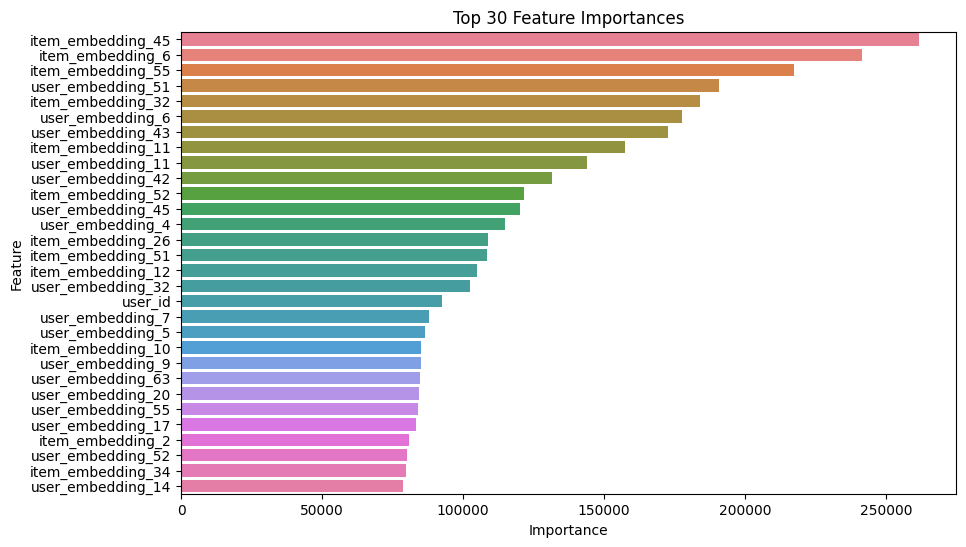

In [12]:
# feature_importanceの上位20個をseabornで可視化する

# 上位20個の特徴量重要度を取得
top_20_features = feature_importance_df.head(30)

# カラフルな色を生成
colors = sns.color_palette("husl", len(top_20_features))

# 可視化
plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=top_20_features, palette=colors)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 30 Feature Importances")
plt.show()


# Ratingを考慮しない場合